In [12]:
import torch
import torch.nn as nn 
from torchvision import models, datasets, transforms
from torchvision.models import ResNet50_Weights, EfficientNet_B7_Weights
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import cv2
import os
import sys
sys.path.append('/Users/anhyojun/WorkSpace/KDT/MyModule')
from KDTModule import *

In [2]:
# 이미지 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 정규화 값
])

# 원본 이미지 경로
ROOT_PATH = '/Users/anhyojun/WorkSpace/LocalData/방범대'
# 회전된 이미지 경로
SAVE_PATH_90 = '/Users/anhyojun/WorkSpace/LocalData/방범대_회전'

# ImageFolder 사용
DS = datasets.ImageFolder(root=ROOT_PATH, transform=transform)

# DataLoader
DL = DataLoader(DS, batch_size = 32, shuffle=True)

print(DS.classes)
print(f'데이터 개수 : {len(DL.dataset)}')

['맹구', '유리', '짱구', '철수', '훈이']
데이터 개수 : 25864


In [3]:
file_path = [i[0] for i in DS.imgs]
labels = [i[1] for i in DS.imgs]

In [4]:
train_path, test_path, train_labels, test_labels = train_test_split(file_path, labels, stratify=labels,
                                                                    random_state = 42, train_size = 0.8)
train_path, valid_path, train_labels, valid_labels = train_test_split(train_path, train_labels,
                                                                      stratify=train_labels,
                                                                      random_state = 42, train_size = 0.8)

In [5]:
class ImagePathDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        super().__init__()
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform != None:
            image = self.transform(image)

        # 레이블 불러오기
        label = self.labels[idx]

        return image, label

In [6]:
trainDS = ImagePathDataset(train_path, train_labels, transform=transform)
validDS = ImagePathDataset(valid_path, valid_labels, transform=transform)
testDS = ImagePathDataset(test_path, test_labels, transform=transform)

trainDL = DataLoader(trainDS, batch_size = 16)
validDL = DataLoader(validDS, batch_size = 16)
testDL = DataLoader(testDS, batch_size = 16)

In [17]:
best_model = models.efficientnet_b7(weights=EfficientNet_B7_Weights)

best_model.classifier = nn.Linear(in_features=2560, out_features=5)

best_model.load_state_dict(torch.load('test.pth', weights_only=True, map_location='mps'))

<All keys matched successfully>

In [30]:
input_data = []
target_data = []
for i, j in validDL:
    input_data.append(i)
    target_data.append(j)
    break

In [32]:
input_data[0].shape

torch.Size([16, 3, 224, 224])

In [33]:
pred_value = torch.argmax(best_model(input_data[0]), dim=1)
pred_value

tensor([2, 0, 0, 3, 2, 4, 2, 1, 4, 0, 2, 0, 4, 3, 1, 1])

In [34]:
real_value = target_data[0]
real_value

tensor([4, 2, 2, 0, 4, 1, 4, 3, 1, 2, 4, 2, 1, 0, 3, 3])

In [48]:
{i : DS.classes[i] for i in range(len(DS.classes))}

{0: '맹구', 1: '유리', 2: '짱구', 3: '철수', 4: '훈이'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


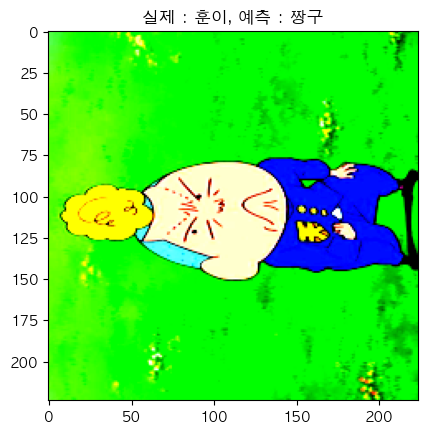

In [49]:
INDEX = 0 # 배치 사이즈 범위 내의 값

name_dict = {i : DS.classes[i] for i in range(len(DS.classes))}
pred_name = name_dict[pred_value[INDEX].item()]
real_name = name_dict[target_data[0][INDEX].item()]
plt.imshow(input_data[0][INDEX].permute(1,2,0))
plt.title(f'실제 : {real_name}, 예측 : {pred_name}')
plt.show()